In [ ]:
# NLP packages
! pip install nltk -U

! pip install seaborn

In [1]:
import torch
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams

[nltk_data] Downloading package punkt_tab to
[nltk_data]     D:\Users\a1910341\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\a1910341\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\a1910341\AppData\Roaming\nltk_data...


In [2]:
alldata = pd.read_excel('alldata.xlsx', sheet_name="alldata")

agg_dict = {col: 'last' for col in alldata.columns if col != 'FOI_TEXT' and col != "MDR_REPORT_KEY"}
agg_dict['FOI_TEXT'] = lambda x: " ".join(x.astype(str))
data = alldata.groupby("MDR_REPORT_KEY").agg(agg_dict).reset_index()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

device cpu


### Task1 : Finding adverse events with Biomedical NER  
- To find more AEs, get labeled dataset then train ClinicalBERT to get overlapped AEs (Ideal failed as ClinicalBERT did not identify the AEs correctly)

In [3]:
TEXTS = data[["MDR_REPORT_KEY", "FOI_TEXT"]]# [:1000]
results = {}
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

for index, row in TEXTS.iterrows():
    # tokenization + removing special characters
    word = re.sub('[^A-Za-z0-9]+', ' ',row["FOI_TEXT"].lower())
    word = re.sub(r'\d', ' ', word)           
    tokens = word_tokenize(word)
    # removing stopwords
    filtered_tokens = [x for x in tokens if x not in stop_words and len(x) > 1]
    # lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    results[row["MDR_REPORT_KEY"]] = lemmatized_tokens

### Task 3: Identify trends of patient age groups/report counts/gender/manufacturers/products for these clusters over 10 years basis

In [4]:
### tag the report with the categories based on these keywords
import ast

ae_groups = pd.read_csv("groups_byClinicalBERT.csv")
combined = pd.read_csv("final_results.csv")

combined["CATEGORIES"] = combined["CATEGORIES"].apply(lambda x: ast.literal_eval(x))
combined = combined[combined["ADVERSE_EVENT_FLAG"] == "Y"]
# ((34936, 130), (16560, 130))

D:\Users\a1910341\AppData\Local\Temp\9\ipykernel_18968\3952163959.py:5: DtypeWarning: Columns (14,17,21,46,47,49,53,55,102,105,111,119,125,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  combined = pd.read_csv("final_results.csv")


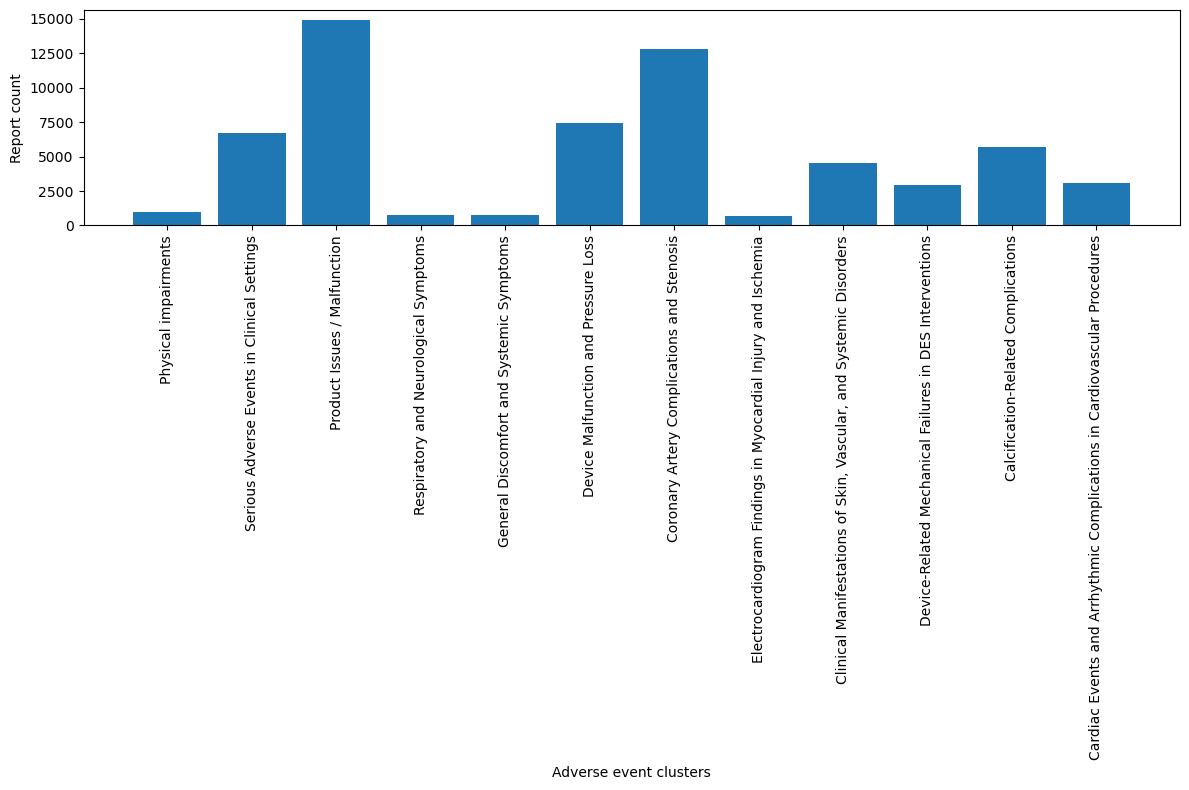

In [5]:
### Examine the report count for each categories
report_count = {}
for group_name in ae_groups.keys():
    report_count[group_name] = 0
for row in combined["CATEGORIES"]:
    for i in row:
        temp = report_count[i]
        temp += 1
        report_count[i] = temp

keys = list(report_count.keys())
values = list(report_count.values())
plt.figure(figsize=(12,8))
plt.bar(keys, values)
plt.xlabel('Adverse event clusters')
plt.ylabel('Report count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
report_count

{'Physical impairments': 956,
 'Serious Adverse Events in Clinical Settings': 6700,
 'Product Issues / Malfunction': 14903,
 'Respiratory and Neurological Symptoms': 776,
 'General Discomfort and Systemic Symptoms': 771,
 'Device Malfunction and Pressure Loss': 7442,
 'Coronary Artery Complications and Stenosis': 12844,
 'Electrocardiogram Findings in Myocardial Injury and Ischemia': 665,
 'Clinical Manifestations of Skin, Vascular, and Systemic Disorders': 4501,
 'Device-Related Mechanical Failures in DES Interventions': 2966,
 'Calcification-Related Complications': 5719,
 'Cardiac Events and Arrhythmic Complications in Cardiovascular Procedures': 3064}

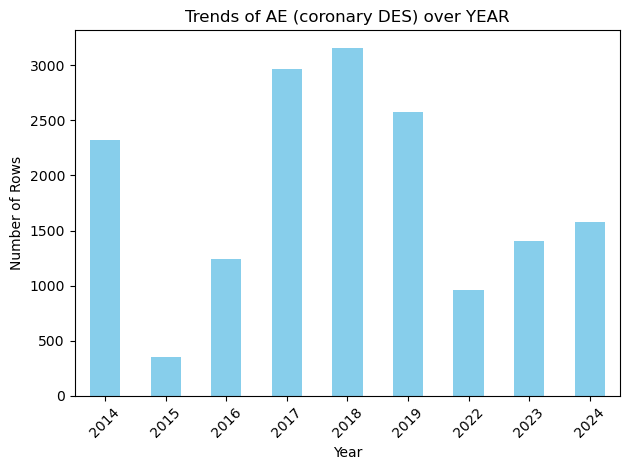

In [7]:
## trends over the year
grouped = combined.groupby('YEAR').size()
grouped.plot(kind='bar', color='skyblue')
plt.title('Trends of AE (coronary DES) over YEAR')
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

In [8]:
#### CLEANING for "PATIENT_AGE" column

# return null for all the age is at least 150, so we can ignore them from analysis
def anomaly(age):
    if int(age) >= 150:
        return None
    else:
        return float(age)
    
def age_cleaning(age):
    age = str(age)
    try:
        if age != "nan":
            if "DA" in age:
                return anomaly(float(re.sub(r"DA", "", age)) / 365)
            elif "MO" in age:
                return anomaly(float(re.sub(r"MO", "", age)) / 12)
            elif "YR" in age:
                return anomaly(float(re.sub(r"YR", "", age)))
            else:
                # assuming this numbers are based in YR
                return float(age)
                
    except Exception as e:
        print(e, age)
        return age

combined["PATIENT_AGE"] = combined["PATIENT_AGE"].apply(lambda x : age_cleaning(x))

#### CLEANING for "PATIENT_WEIGHT" column
combined["PATIENT_WEIGHT"] = combined["PATIENT_WEIGHT"].apply(lambda x : float(re.sub(r"KG", "", str(x))) if x is not None else None)

# Flatten the combined data
flatten_combined = combined.explode('CATEGORIES').reset_index(drop=True)

###### remove the outliers for patient weight with z-score
from scipy import stats
df_weight = combined.dropna(subset=['PATIENT_WEIGHT'])
# Calculate Z-scores
z_scores = stats.zscore(df_weight['PATIENT_WEIGHT'])
df_filtered_weight = df_weight[(abs(z_scores) < 3)]
###### END

###### remove the outliers for patient age with z-score
from scipy import stats
df_age = combined.dropna(subset=['PATIENT_AGE'])
# Calculate Z-scores
z_scores = stats.zscore(df_age['PATIENT_AGE'])
df_filtered_age = df_age[(abs(z_scores) < 3)]
###### END

In [ ]:
flatten_combined.to_csv("flatten_final_results.csv", index=False)

#### General understanding on patient demographic

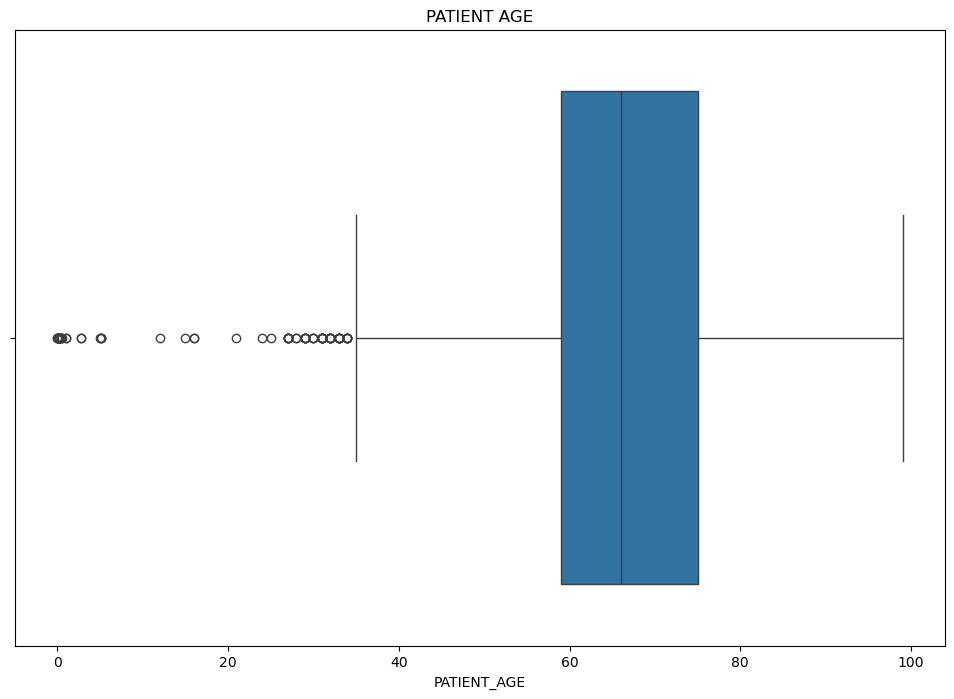

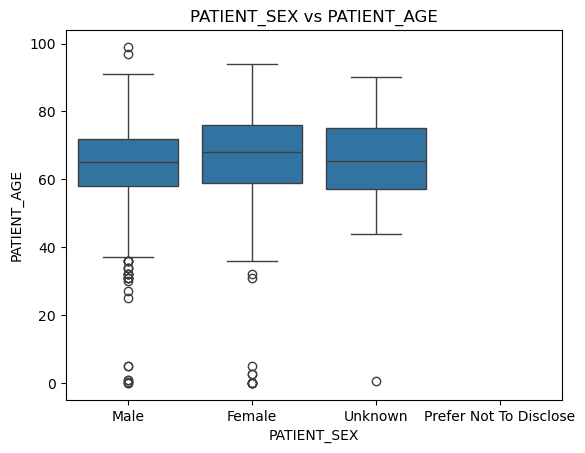

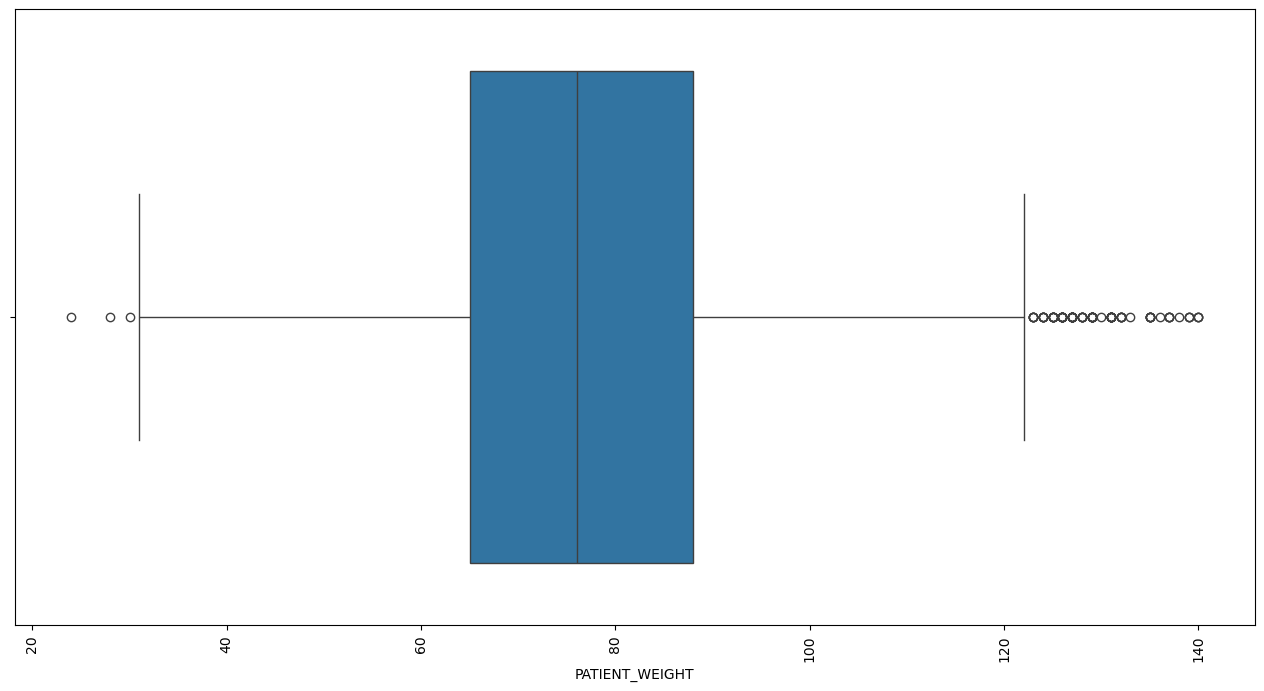

In [9]:
#### plot 3 figures to show patient's demographic
plt.figure(figsize=(12, 8))
sns.boxplot(combined, x="PATIENT_AGE")
plt.title("PATIENT AGE")
plt.show()

# patient gender against age
sns.boxplot(combined, x = "PATIENT_SEX", y = "PATIENT_AGE")
plt.title("PATIENT_SEX vs PATIENT_AGE")
plt.show()

# patient weight
plt.figure(figsize=(16, 8))
sns.boxplot(df_filtered_weight, x = "PATIENT_WEIGHT")
plt.xticks(rotation=90)
plt.show()

#### General understanding of how patient demographic differs across different categories

In [ ]:
# df_filtered_age = df_filtered_age.explode("CATEGORIES").reset_index(drop=False)
# df_filtered_weight = df_filtered_weight.explode("CATEGORIES").reset_index(drop=False)

### Examine the patient demographic with these AE clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='CATEGORIES', y='PATIENT_AGE', data=df_filtered_age)
plt.title('Patient Age Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Age')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='CATEGORIES', hue='PATIENT_SEX', data=flatten_combined)
plt.title('Patient Gender Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Gender')
plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='CATEGORIES', y='PATIENT_WEIGHT', data=df_filtered_weight)
plt.title('Patient Weight Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Weight')
plt.xticks(rotation=90)
plt.show()

#### General understanding on how products and manufacturers changes across each different categories

In [11]:
# which products has most problem for each category and 
temp = flatten_combined.copy()
columns = temp["CATEGORIES"].unique()
for i in columns:
    top5_brands = temp[temp["CATEGORIES"] == i]['BRAND_NAME'].value_counts().head(5)
    print(f"For {i}:")
    print(top5_brands, "\n")


## what are the corresponding manufacturers
for i in columns:
    top5_manufacturers = temp[temp["CATEGORIES"] == i]['MANUFACTURER_D_NAME'].value_counts().head(5)
    print(f"For {i}:")
    print(top5_manufacturers, "\n")


For Serious Adverse Events in Clinical Settings:
BRAND_NAME
XIENCE XPEDITION EVEROLIMUS ELUTING CORONARY STENT SYSTEM    686
RESOLUTE ONYX RX                                             643
XIENCE ALPINE EVEROLIMUS ELUTING CORONARY STENT SYSTEM       602
XIENCE PRIME EVEROLIMUS ELUTING CORONARY STENT SYSTEM        483
RESOLUTE INTEGRITY RX                                        427
Name: count, dtype: int64 

For Product Issues / Malfunction:
BRAND_NAME
RESOLUTE ONYX RX                                             2108
XIENCE ALPINE EVEROLIMUS ELUTING CORONARY STENT SYSTEM       1170
XIENCE XPEDITION EVEROLIMUS ELUTING CORONARY STENT SYSTEM    1147
SYNERGY                                                       831
XIENCE PRIME EVEROLIMUS ELUTING CORONARY STENT SYSTEM         697
Name: count, dtype: int64 

For Coronary Artery Complications and Stenosis:
BRAND_NAME
RESOLUTE ONYX RX                                             1365
XIENCE XPEDITION EVEROLIMUS ELUTING CORONARY STENT SYSTEM  

#### Then for each top 5 products / manufacturers, plot their AE changes across year


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get all top 5 brands across categories
top_brands_all_categories = set()
top_manufacturers_all_categories = set()

for cat in temp["CATEGORIES"].unique():
    top_brands = (
        temp[temp["CATEGORIES"] == cat]["BRAND_NAME"]
        .value_counts()
        .head(5)
        .index.tolist()
    )
    top_brands_all_categories.update(top_brands)
    
for name in temp["CATEGORIES"].unique():
    top_brands = (
        temp[temp["CATEGORIES"] == name]["MANUFACTURER_D_NAME"]
        .value_counts()
        .head(5)
        .index.tolist()
    )
    top_manufacturers_all_categories.update(top_brands)

print(top_brands_all_categories)
print(top_manufacturers_all_categories)

{'XIENCE XPEDITION 48 EVEROLIMUS ELUTING CORONARY STENT SYSTEM', 'PROMUS ELEMENT? PLUS', 'XIENCE PRIME EVEROLIMUS ELUTING CORONARY STENT SYSTEM', 'SYNERGY', 'ONYX FRONTIER', 'XIENCE XPEDITION EVEROLIMUS ELUTING CORONARY STENT SYSTEM', 'RESOLUTE ONYX RX', 'SYNERGYÂ¿', 'SYNERGY II EVEROLIMUS-ELUTING PLATINUM CHROMIUM CORONARY STENT SYSTEM', 'PROMUS PREMIER', 'XIENCE SIERRA EVEROLIMUS ELUTING CORONARY STENT SYSTEM', 'TAXUSÂ® LIBERTÃ‰Â®', 'PROMUS ELEMENTÂ¿ PLUS', 'RESOLUTE INTEGRITY RX', 'XIENCE ALPINE EVEROLIMUS ELUTING CORONARY STENT SYSTEM'}
{'MEDTRONIC IRELAND', 'BOSTON SCIENTIFIC CORPORATION', 'BOSTON SCIENTIFIC - GALWAY', 'ABBOTT VASCULAR', 'BOSTON SCIENTIFIC - MAPLE GROVE', 'AV-TEMECULA-CT'}


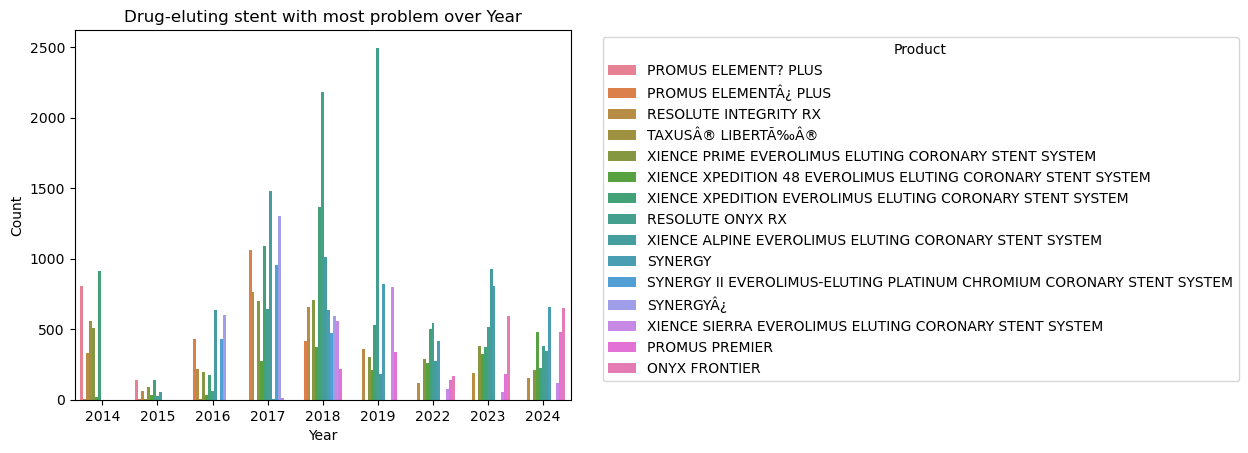

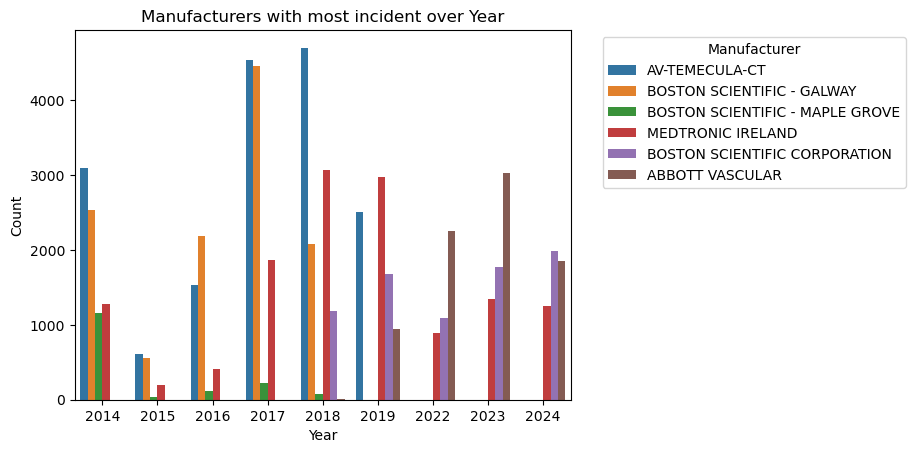

In [13]:
filtered = temp[temp["BRAND_NAME"].isin(top_brands_all_categories)]
grouped = filtered.groupby(['YEAR', 'BRAND_NAME']).size().reset_index(name='count')
sns.barplot(data=grouped, x='YEAR', y='count', hue='BRAND_NAME')
plt.title('Drug-eluting stent with most problem over Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

filtered = temp[temp["MANUFACTURER_D_NAME"].isin(top_manufacturers_all_categories)]
grouped = filtered.groupby(['YEAR', 'MANUFACTURER_D_NAME']).size().reset_index(name='count')
sns.barplot(data=grouped, x='YEAR', y='count', hue='MANUFACTURER_D_NAME')
plt.title('Manufacturers with most incident over Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Manufacturer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
### logistic regression to find the factors that significantly affecting each categories


### Task 5: Building a PowerBI dashboard to show overall results such as 
- trends of report counts for each clusters
- percentage difference for these clusters over years

### Task 6: Building RAG Chatbot that read the csv file (in fixed format), then able to answer question based on these new reports